In [39]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import utils
from model import UNet

In [40]:
BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
trans = transforms.ToTensor()
reverse_trans = transforms.ToPILImage()
train_set = datasets.MNIST("data", train=True, download=True, transform=trans)
test_set = datasets.MNIST("data", train=False, download=True, transform=trans)

In [42]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=4)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=4)

torch.Size([1, 1, 28, 28])
(28, 28)


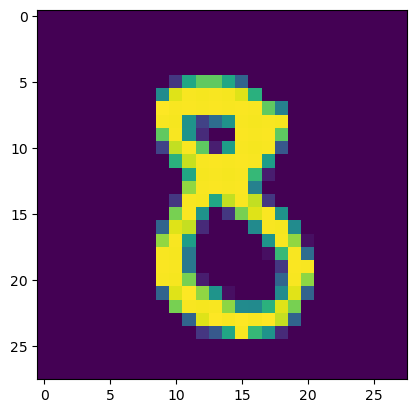

In [43]:
for (X, y) in train_loader:
    print(X.size())

    CHANNELS = X.size()[1]
    IMG_SIZE = X.size()[2]

    img = reverse_trans(X.squeeze())
    print(img.size)
    plt.imshow(img)
    break

In [44]:
def beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02

    return torch.linspace(beta_start, beta_end, timesteps)

In [45]:
TIMESTEPS = 200
betas = beta_schedule(TIMESTEPS)
alphas = 1.0 - betas

alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1 / alphas)

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

In [46]:
def extract(vec, t, x_shape):
    batch_size = t.shape[0]
    out = vec.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [47]:
def get_noisy_image(x_start, step, noise=None):
    if noise == None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, step, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, step, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [48]:
for (X, y) in train_loader:
    imgs = [get_noisy_image(X, torch.tensor([t])) for t in [0, 50, 100, 150, 199]]
    for img in imgs:
        img = reverse_trans(img.squeeze())
    utils.plot(imgs)
    break

In [49]:
def get_denoised_image(x, step, model):
    betas_t = extract(betas, step, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, step, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, step, x.shape)

    model_mean = sqrt_recip_alphas_t * (x - betas_t  * model(x, step) / sqrt_one_minus_alphas_cumprod_t)

    if step == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        posterior_variance_t = extract(posterior_variance, step)
        return model_mean + noise * posterior_variance

In [50]:
def get_denoised_images(shape, timesteps, model):
    device = next(model.parameters()).device
    b_size = shape[0]

    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = get_denoised_image(model, img, torch.full((b_size,), i, device=device, dtype=torch.long))
        imgs.append(img.cpu().numpy())
    return imgs

In [51]:
def sample(model, img_size, batch_size=16, channels=3):
    return get_denoised_images((batch_size, channels, img_size, img_size))

In [52]:
def diff_loss(x_start, step, model, loss_type='huber'):
    noise = torch.randn_like(x_start)

    noisy_img = get_noisy_image(x_start, step, noise=noise)
    predicted_noise = model(noisy_img, step)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == 'huber':
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [53]:
EPOCHS = 5
LR = 1e-3

# model = UNet()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# device = "cuda" if torch.cuda.is_available() else "cpu"

# index = 0
# for epoch in range(EPOCHS):
#     for (X, y) in train_loader:
#         optimizer.zero_grad()
#         X.to(device)

#         step = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device)
#         loss = diff_loss(X, step, model)

#         loss.backward()
#         optimizer.step()

#         index += 1
#         if (index % 100 == 0):
#             print(f"Loss: {loss.item()}")

